# Class Challenge: Image Classification of COVID-19 X-rays
# Task 1 [Total points: 30]

## Setup

* This assignment involves the following packages: 'matplotlib', 'numpy', and 'sklearn'. 

* If you are using conda, use the following commands to install the above packages:<br>
```shell
conda install matplotlib
conda install numpy
conda install -c anaconda scikit-learn
```

* If you are using pip, use use the following commands to install the above packages: <br> 
```shell
pip install matplotlib
pip install numpy
pip install sklearn
```

## Data

Please download the data using the following link: [COVID-19](https://drive.google.com/file/d/1Y88tgqpQ1Pjko_7rntcPowOJs_QNOrJ-/view). 

* After downloading 'Covid_Data_GradientCrescent.zip', unzip the file and you should see the following data structure:


|--all<br>
|--------train<br>
|--------test<br>
|--two<br>
|--------train<br>
|--------test<br>


* Put the 'all' folder, the 'two' folder and this python notebook in the **same directory** so that the following code can correctly locate the data.  



## [20 points] Binary Classification: COVID-19 vs. Normal

In [1]:
import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16

import warnings
warnings.filterwarnings('ignore')

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
tf.__version__

'2.0.0'

#### Load Image Data

In [2]:
DATA_LIST = os.listdir('two/train')
DATASET_PATH  = 'two/train'
TEST_DIR =  'two/test'
IMAGE_SIZE    = (224, 224)
NUM_CLASSES   = len(DATA_LIST)
BATCH_SIZE    = 10 # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS    = 40
LEARNING_RATE = 0.0005 # start off with high rate first 0.001 and experiment with reducing it gradually 

#### Generate Training and Validation Batches

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=50,featurewise_center = True,
                                   featurewise_std_normalization = True,width_shift_range=0.2,
                                   height_shift_range=0.2,shear_range=0.25,zoom_range=0.1,
                                   zca_whitening = True,channel_shift_range = 20,
                                   horizontal_flip = True,vertical_flip = True,
                                   validation_split = 0.2,fill_mode='constant')

train_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "training",seed=42,
                                                  class_mode="binary")

valid_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "validation",seed=42,
                                                  class_mode="binary")

Found 104 images belonging to 2 classes.
Found 26 images belonging to 2 classes.


#### [10 points] Build Model
Hint: Starting from a pre-trained model typically helps performance on a new task, e.g. starting with weights obtained by training on ImageNet. 

In [4]:
vgg_16 = VGG16(weights = 'imagenet', include_top = False, \
              input_shape = (224,224,3), classes = NUM_CLASSES)

for layer in vgg_16.layers:
  layer.trainable = False

model = tf.keras.models.Sequential()

model.add(vgg_16)

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dropout(.25))

model.add(tf.keras.layers.Dense(256, activation = 'relu'))

model.add(tf.keras.layers.Dropout(.15))

model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 21,137,729
Trainable params: 6,423,041
Non-trainable params: 14,714,688
____________________________________

#### [5 points] Train Model

In [5]:
#FIT MODEL
print(len(train_batches))
print(len(valid_batches))

STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size

OPTIMIZER = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE)

model.compile(optimizer = OPTIMIZER, \
                loss=tf.keras.losses.BinaryCrossentropy(), \
                metrics=['accuracy'])


history = model.fit(train_batches, steps_per_epoch = STEP_SIZE_TRAIN, \
                    epochs = NUM_EPOCHS, validation_data = valid_batches, \
                    validation_steps = STEP_SIZE_VALID)

11
3
Train for 10 steps, validate for 2 steps
Epoch 1/40
10/10 [==============================] - 34s 3s/step - loss: 1.9919 - accuracy: 0.5106 - val_loss: 0.5776 - val_accuracy: 0.5500
Epoch 2/40
10/10 [==============================] - 30s 3s/step - loss: 0.5644 - accuracy: 0.6702 - val_loss: 0.2974 - val_accuracy: 0.9000
Epoch 3/40
10/10 [==============================] - 31s 3s/step - loss: 0.4104 - accuracy: 0.8298 - val_loss: 0.2258 - val_accuracy: 0.9000
Epoch 4/40
10/10 [==============================] - 34s 3s/step - loss: 0.3020 - accuracy: 0.8723 - val_loss: 0.1001 - val_accuracy: 1.0000
Epoch 5/40
10/10 [==============================] - 30s 3s/step - loss: 0.1807 - accuracy: 0.9362 - val_loss: 0.1158 - val_accuracy: 1.0000
Epoch 6/40
10/10 [==============================] - 35s 3s/step - loss: 0.2187 - accuracy: 0.9362 - val_loss: 0.1816 - val_accuracy: 0.9500
Epoch 7/40
10/10 [==============================] - 33s 3s/step - loss: 0.2517 - accuracy: 0.8617 - val_loss: 0.12

#### [5 points] Plot Accuracy and Loss During Training

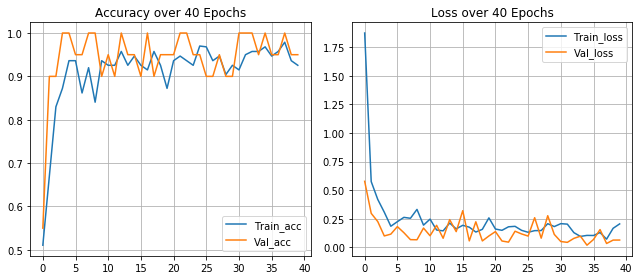

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize = (9,4))

plt.subplot(1, 2, 1)
plt.grid()
plt.plot(history.history['accuracy'], label='Train_acc')
plt.plot(history.history['val_accuracy'], label = 'Val_acc')
plt.title("Accuracy over 40 Epochs")
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.grid()
plt.plot(history.history['loss'], label='Train_loss')
plt.plot(history.history['val_loss'], label = 'Val_loss')
plt.title("Loss over 40 Epochs")
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

#### Plot Test Results

Found 18 images belonging to 2 classes.
18/18 [==============================] - 5s 286ms/step
covid\nejmoa2001191_f3-PA.jpeg


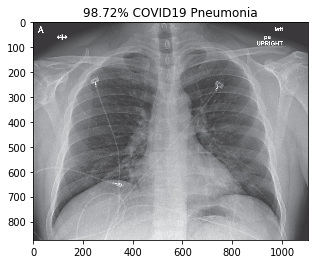

covid\nejmoa2001191_f4.jpeg


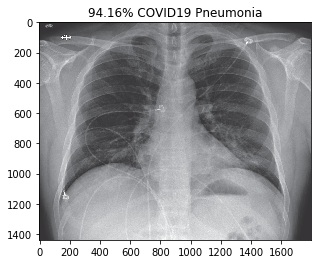

covid\nejmoa2001191_f5-PA.jpeg


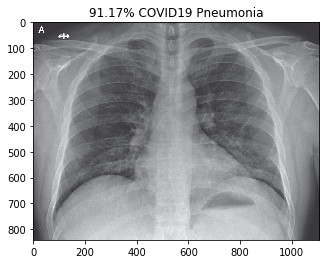

covid\radiol.2020200490.fig3.jpeg


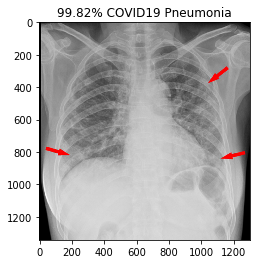

covid\ryct.2020200028.fig1a.jpeg


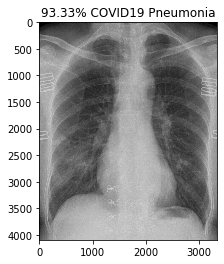

covid\ryct.2020200034.fig2.jpeg


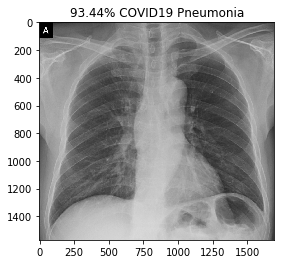

covid\ryct.2020200034.fig5-day0.jpeg


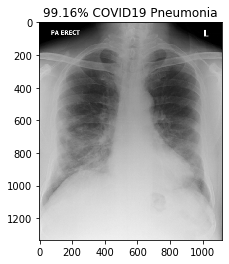

covid\ryct.2020200034.fig5-day4.jpeg


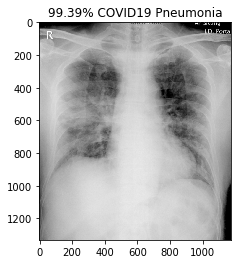

covid\ryct.2020200034.fig5-day7.jpeg


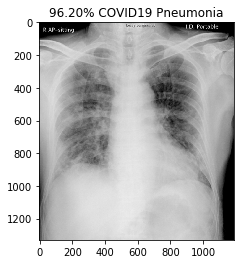

normal\NORMAL2-IM-1385-0001.jpeg


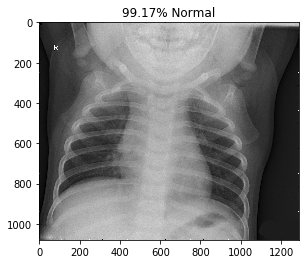

normal\NORMAL2-IM-1396-0001.jpeg


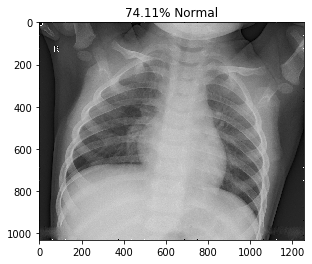

normal\NORMAL2-IM-1400-0001.jpeg


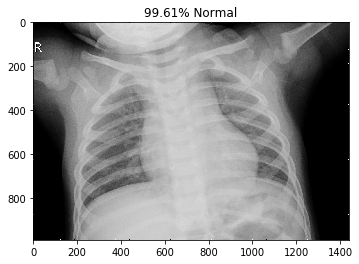

normal\NORMAL2-IM-1401-0001.jpeg


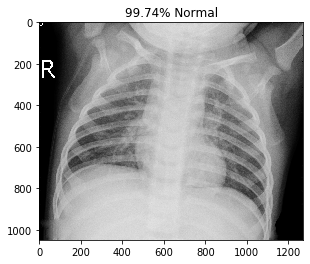

normal\NORMAL2-IM-1406-0001.jpeg


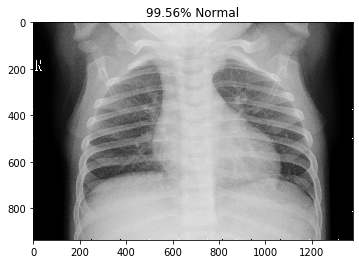

normal\NORMAL2-IM-1412-0001.jpeg


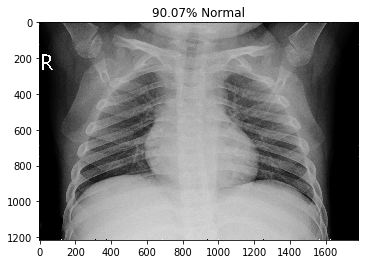

normal\NORMAL2-IM-1419-0001.jpeg


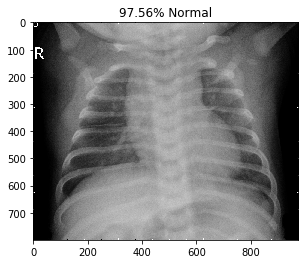

normal\NORMAL2-IM-1422-0001.jpeg


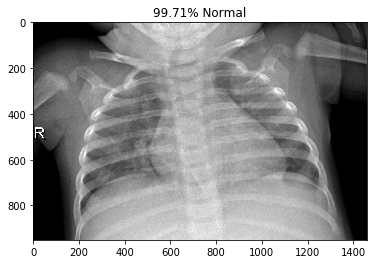

normal\NORMAL2-IM-1423-0001.jpeg


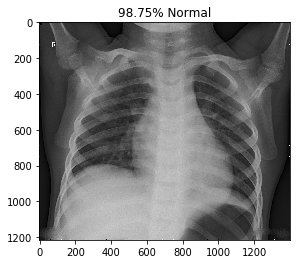

In [7]:
import matplotlib.image as mpimg

test_datagen = ImageDataGenerator(rescale=1. / 255)
eval_generator = test_datagen.flow_from_directory(TEST_DIR,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=False,seed=42,class_mode="binary")
eval_generator.reset()
pred = model.predict_generator(eval_generator,18,verbose=1)
for index, probability in enumerate(pred):
    image_path = TEST_DIR + "/" +eval_generator.filenames[index]
    image = mpimg.imread(image_path)
    if image.ndim < 3:
        image = np.reshape(image,(image.shape[0],image.shape[1],1))
        image = np.concatenate([image, image, image], 2)
#         print(image.shape)

    pixels = np.array(image)
    plt.imshow(pixels)
    
    print(eval_generator.filenames[index])
    if probability > 0.5:
        plt.title("%.2f" % (probability[0]*100) + "% Normal")
    else:
        plt.title("%.2f" % ((1-probability[0])*100) + "% COVID19 Pneumonia")
    plt.show()

## [10 points] TSNE Plot
t-Distributed Stochastic Neighbor Embedding (t-SNE) is a widely used technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. After training is complete, extract features from a specific deep layer of your choice, use t-SNE to reduce the dimensionality of your extracted features to 2 dimensions and plot the resulting 2D features.

Found 130 images belonging to 2 classes.


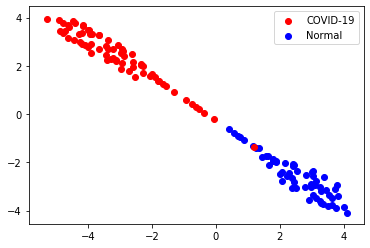

In [8]:
from sklearn.manifold import TSNE

intermediate_layer_model = tf.keras.models.Model(inputs=model.input, \
                                      outputs=model.get_layer('dense').output)

tsne_data_generator = test_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE, \
                                                  batch_size=1,shuffle=False,seed=42,class_mode="binary")

features = intermediate_layer_model.predict_generator(tsne_data_generator)


labels = []

for i in range(len(tsne_data_generator)):
    labels.extend(tsne_data_generator.__getitem__(i)[1])

tsne = TSNE(perplexity = 50, learning_rate = 80).fit_transform(features)

for i in range(len(tsne)):
    if labels[i] == 1.0: 
        # covid
        c = plt.scatter(tsne[:,0][i], tsne[:,1][i], color = 'red')
    else:
        # normal
        n = plt.scatter(tsne[:,0][i], tsne[:,1][i], color = 'blue')

plt.legend((c, n), ("COVID-19", "Normal"))

plt.show()